The following looks at the Pacific-North American Index (monthly, though I looked at daily on my own as well) from 1950 to present. PNA is a teleconnection used to describe East Asian jet variations that have temperature and precipitation consequences downstream in the North American extratropics. 

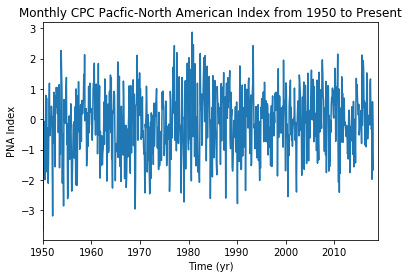

In [13]:
#Dataset from KNMI (https://climexp.knmi.nl/getstations.cgi)
#Precipitation (mm/day) 
#Cape Florida, FL
#Lat: 26N lon: 80W

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal

q=Dataset('icpc_pna.nc','r',format='NETCDF')  
#print(q.variables) 
t = np.array(q.variables['time'])   #time
pna = np.array(q.variables['PNA'])   #PNA
pna[pna==3e+33]=np.nan                  #Remove nans
t = t[~np.isnan(pna)]
pna = pna[~np.isnan(pna)]
t = t/12. + 1950

plt.plot(t,pna)
plt.xlabel('Time (yr)');plt.ylabel('PNA Index');
plt.xlim([1950,2019])
plt.title('Monthly CPC Pacfic-North American Index from 1950 to Present');

The first power spectrum peak is about 5.680555555555556 years
The second power spectrum peak is about 1.002450980392157 years
The third power spectrum peak is about 7.175438596491228 months


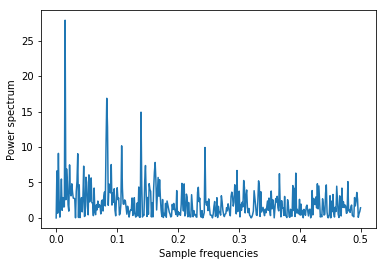

In [14]:
#Calculate the power spectrum of the time series

f, Pxx = signal.periodogram(pna) # Daily periodicity
plt.plot(f,Pxx)
plt.ylabel('Power spectrum');plt.xlabel('Sample frequencies');
max_i = Pxx.argsort()[-3:][::-1] # returns array of indices of first 3 maximum values

# at what freq is that max value?
max_freq1 = f[max_i[0]]
max_freq2 = f[max_i[1]]
max_freq3 = f[max_i[2]]

# convert back to years
max_time1 = (1. / max_freq1) /12.
max_time2 = (1. / max_freq2) /12.
max_time3 = (1. / max_freq3) 

print('The first power spectrum peak is about '+str(max_time1)+' years')
print('The second power spectrum peak is about '+str(max_time2)+' years')
print('The third power spectrum peak is about '+str(max_time3)+' months')


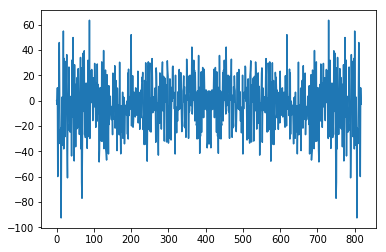

In [15]:
# Take the simple FFT, after removing the mean

pna_r = pna - pna.mean()

#To match the sign above, roll the array so it starts at t=0. 
# Vp = np.roll(Vp, int(-NT/2) ) Too fussy: just know the sign is opposite

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
pna_spec = np.fft.fft( pna_r )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(pna_spec.real)
#ax.plot(Vspec.imag)

Text(0,0.5,'Some measure of cosine component amplitude')

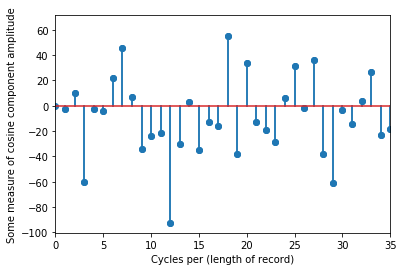

In [16]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
NT = len(pna_spec)
N = 30 # number of sinusoidal functions(?)

freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, pna_spec.real)
ax.set_xlim([0,N + 5])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')

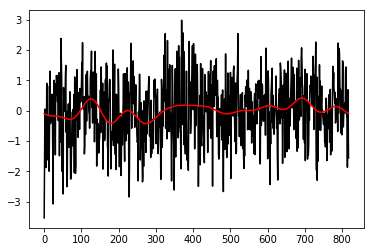

In [17]:
# Mess with the spectrum and reconstruct (a way of filtering)

# Truncate the frequencies higher then TRUNC cycles per record length
TRUNC = 10

pna_trunc = pna_spec.copy()
pna_trunc[np.where(freqs > TRUNC)] *= 0. 
pna_recon = np.fft.ifft(pna_trunc).real

# How's the reconstruction? 
fig,ax=plt.subplots(1,1) 
ax.plot(pna_r,      color='black')
ax.plot(pna_recon,  color='red')

Variance is 1.0723137 (PNA INDEX^2): matches 1.0723136663436899
Frequency refers to 5.680555555555556years


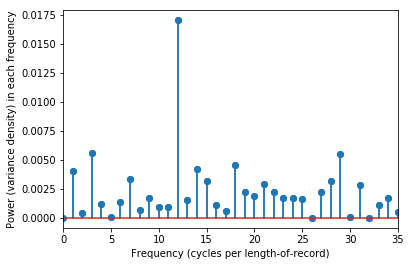

In [12]:
# Complex conjugate does the squaring
Power = (pna_spec.conjugate()*pna_spec).real
Power *= np.var(pna_r) / Power.sum()       # Enforce Parseval's theorem for variance 
fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Power)
ax.set_xlim([0,N + 5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Power (variance density) in each frequency')

print('Variance is', pna_r.var(), '(PNA INDEX^2): matches', sum(Power))

max_i = np.argmax(Power) # returns index of max Power
max_freq = f[max_i] # at what freq is that max value?
freq_t = (1./max_freq)/12.
print('Frequency refers to '+str(freq_t)+'years')

Text(0,0.5,'Phase angle atan(cosine_part/sine_part) in each frequency')

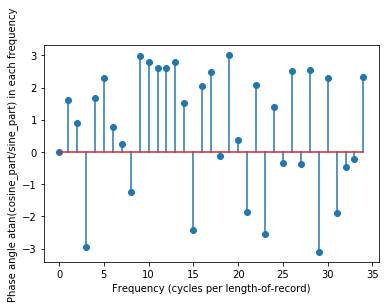

In [18]:
# Phase angle of complex number
Phase = np.angle(pna_spec)

fig,ax=plt.subplots(1,1) 
ax.stem(freqs[0:N+5], Phase[0:N+5])
ax.set_xlabel('Frequency (cycles per length-of-record)')
ax.set_ylabel('Phase angle atan(cosine_part/sine_part) in each frequency')

1.0723136909502549 1.0723137


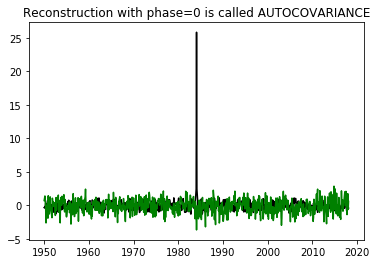

In [21]:
# Reconstruct with phase angle all set to 0 (all components set to pure cosine)
FakePhase = Phase *0 

# Construct a spectrum using that fake phase info
FakeSpec = np.abs(pna_spec) * np.exp(1j*FakePhase)
pna_recon = np.fft.ifft(FakeSpec).real

# For clarity, let's roll it into the [-pi,pi] axis
fig,ax=plt.subplots(1,1) 
ax.plot(t, np.roll(pna_recon,    int(NT/2)), color='black')
ax.plot(t, np.roll(pna,int(NT/2)), color='green')
ax.set_title('Reconstruction with phase=0 is called AUTOCOVARIANCE')

# Has same variance, but all packed at a spike that acts as a sort of "composite excursion"
print(pna_recon.var(), pna.var())